<a href="https://colab.research.google.com/github/ccollado7/proyecto_vocales/blob/main/k_means_vocales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Modulos

In [1]:
import sys
import os.path
from os import path

def is_runing_into_colab_env():
    try:
        import google.colab
        return True
    except:
        return False

if is_runing_into_colab_env():
    if path.exists('/content/proyecto_vocales'):
        print('Pull...\n')
        !cd proyecto_vocales; git pull origin main
    else:
        print('Clone...\n')
        !git clone https://github.com/ccollado7/proyecto_vocales

if is_runing_into_colab_env():
    !pip install praat-parselmouth

Clone...

Cloning into 'proyecto_vocales'...
remote: Enumerating objects: 226, done.
remote: Counting objects: 100% (222/222), done.
remote: Compressing objects: 100% (177/177), done.
remote: Total 226 (delta 67), reused 187 (delta 39), pack-reused 4
Receiving objects: 100% (226/226), 1.20 MiB | 21.22 MiB/s, done.
Resolving deltas: 100% (67/67), done.
     |████████████████████████████████| 10.7 MB 22.9 MB/s 


In [2]:
sys.path.append('/content/proyecto_vocales/src')

In [3]:
#Generales
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import io
import glob
from pathlib import Path

#Audio
!pip install praat-parselmouth
from parselmouth import praat
import parselmouth 

#propios
from fwav2df import extract_formants, \
                    prepare_dataframe, \
                    read_audios_procesados

from graph import graph_svm

#No Supervisados
from sklearn.cluster import KMeans
from sklearn import svm

#Supervisados
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

## 2. Lectura de datos - Dataframe

Leer archivos ya procesados y armar el dataset

In [4]:
url = 'https://raw.githubusercontent.com/ccollado7/proyecto_vocales/main/data/raw/features_'
df=read_audios_procesados(url)

In [5]:
df.head()

,0,1,target
0,1002.20,1549.3,A
1,961.18,1440.7,A
2,810.06,1250.7,A
3,779.54,1214.8,A
4,948.24,1506.8,A


**Función de extracción de formantes**

Si bien los audios con vocales son señales temporales, se aproximan por sus formates del espectro.

`(https://www.fceia.unr.edu.ar/prodivoz/home_index.html)` | [Prodivoz](https://www.fceia.unr.edu.ar/prodivoz/home_index.html)

In [10]:
folder_wav_contents=glob.glob('proyecto_vocales/data/raw/wav/*.wav')
df=prepare_dataframe(folder_wav_contents,funcion='lpc_rf')

In [11]:
df.head()

,0,1,target
39,1002.0,1550.0,A
40,948.0,1506.0,A
2,780.0,1214.0,A
4,766.0,1234.0,A
53,810.0,1250.0,A


In [50]:
df.columns

Index([0, 1, 'target'], dtype='object')

**Alternativa para extraer formantes Praat**

`(https://parselmouth.readthedocs.io/en/stable/)` | [Parselmouth](https://parselmouth.readthedocs.io/en/stable/) 


In [8]:
def extract_praat(file_path):
    sound = parselmouth.Sound(file_path)
    formants = praat.call(sound, "To Formant (burg)", 0.025, 5, 8000, 0.05, 50)# 5 formantes recomendado
    f1_list = []
    f2_list = []
    f_mean=[]
    #f3_list = []
    for i in range(2, formants.get_number_of_frames()+1):
        f1 = formants.get_value_at_time(1, formants.get_time_step()*i)
        f2 = formants.get_value_at_time(2, formants.get_time_step()*i)
        f3 = formants.get_value_at_time(3, formants.get_time_step()*i)
        f1_list.append(f1)
        f2_list.append(f2)
        #f3_list.append(f3)
    f_mean.append(np.mean(f1_list))
    f_mean.append(np.mean(f2_list))
    #f_mean.append(np.median(f3_list))
    return pd.DataFrame(f_mean).transpose()

In [9]:
folder_wav_contents=glob.glob('proyecto_vocales/data/raw/wav/*.wav')

df=pd.DataFrame()
for file_path in folder_wav_contents:
    filename = Path(file_path).stem
    filename_parts = filename.split('_')
    metadata = {'file_path': file_path,
              'vocal': filename_parts[0],
              'id': filename_parts[1]}
    df1=extract_praat(file_path)
    df1['target']=filename_parts[0]
    df=pd.concat([df, df1], axis=0).reset_index(drop=True)

df['target']=df['target'].str.upper()
df.sort_values(by=['target'], ascending=True,inplace=True)

## 3. Analisis Exploratorio

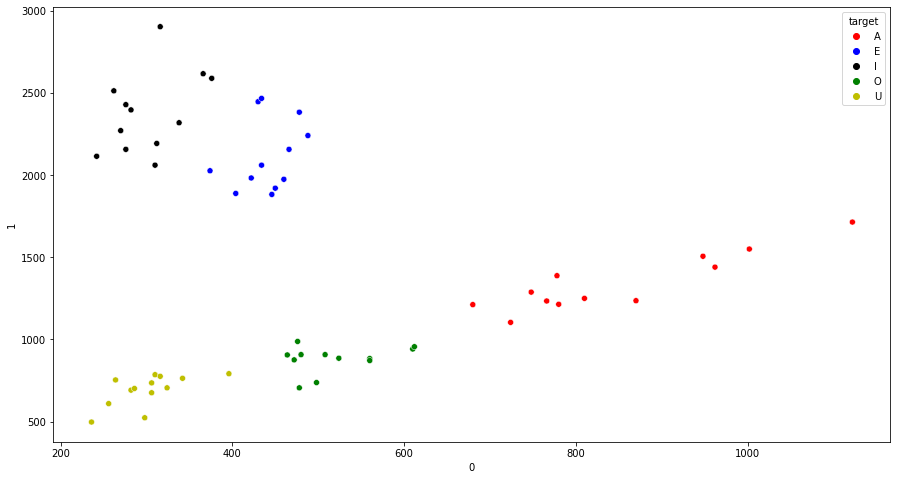

In [12]:
plt.figure(figsize=(15,8))
sns.scatterplot(x=0,y=1,hue='target',palette={'A':'r','E':'b','I':'k','O':'g','U':'y'},data=df,legend='brief')

### 3.1 Atributo 0

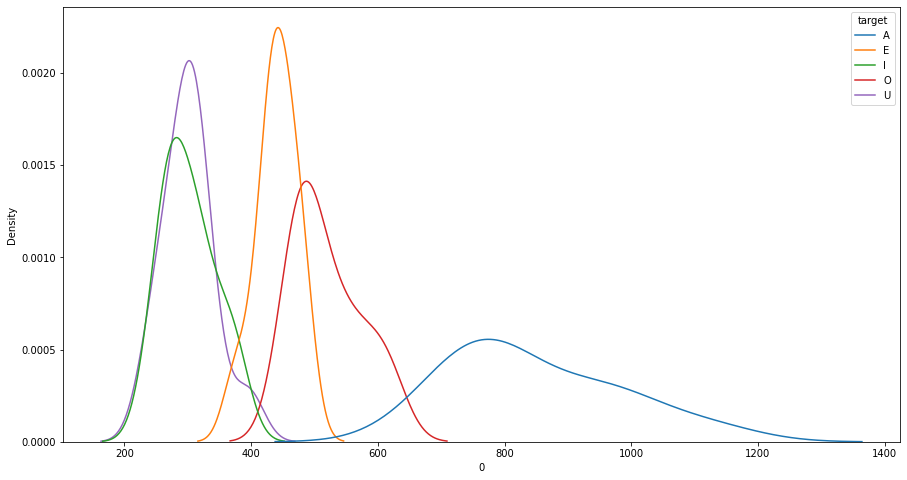

In [13]:
plt.figure(figsize=(15,8))
sns.kdeplot(data=df, x=0, hue="target")

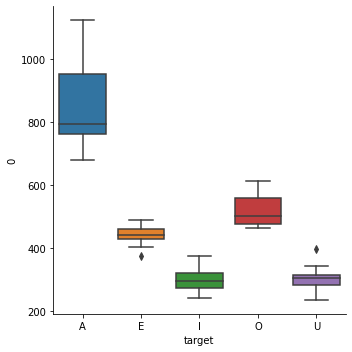

In [14]:
sns.catplot(x="target", y=0, kind="box", data=df)

### 3.2 Atributo 2

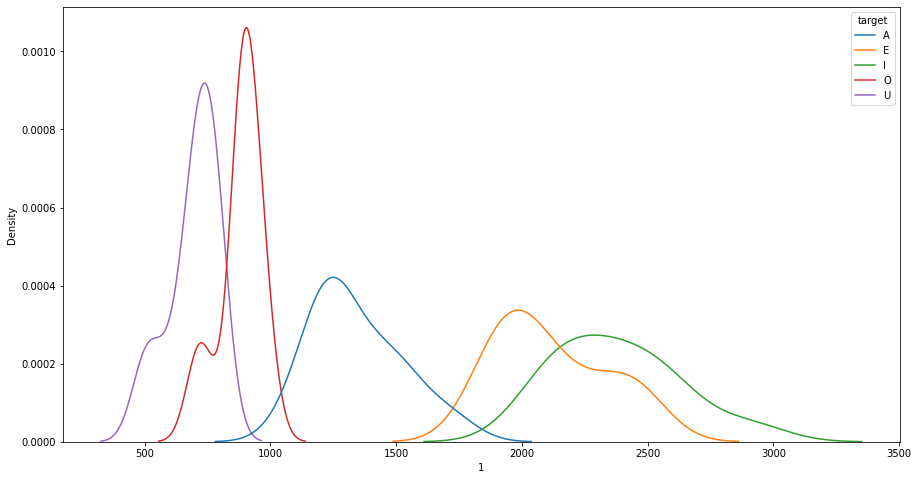

In [15]:
plt.figure(figsize=(15,8))
sns.kdeplot(data=df, x=1, hue="target")

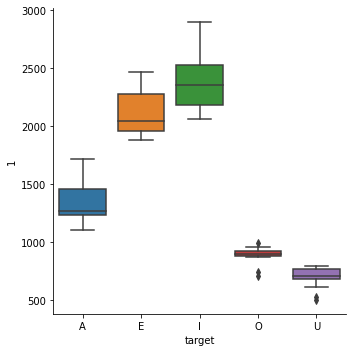

In [16]:
sns.catplot(x="target", y=1, kind="box", data=df)

### 3.3 Target

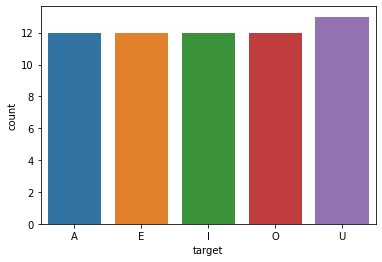

In [17]:
sns.countplot(x="target", data=df)

## 4. Metodos No Supervisados

### 4.1 Método kmeans

In [18]:
X=df[[0,1]]
X.head()

,0,1
39,1002.0,1550.0
40,948.0,1506.0
2,780.0,1214.0
4,766.0,1234.0
53,810.0,1250.0


In [19]:
y=df[['target']]
y.head()

,target
39,A
40,A
2,A
4,A
53,A


In [20]:
kmeans = KMeans(n_clusters=5).fit(X)

In [21]:
print(kmeans.labels_)
print(kmeans.cluster_centers_)

[4 4 4 4 4 4 1 4 4 4 4 4 3 0 3 3 3 3 3 3 0 3 0 3 0 3 0 3 0 0 3 0 0 0 3 0 1
 2 2 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2]
[[ 348.         2484.        ]
 [ 544.54545455  930.        ]
 [ 326.53333333  697.33333333]
 [ 391.07692308 2050.        ]
 [ 860.54545455 1366.54545455]]


([], <a list of 0 Text major ticklabel objects>)

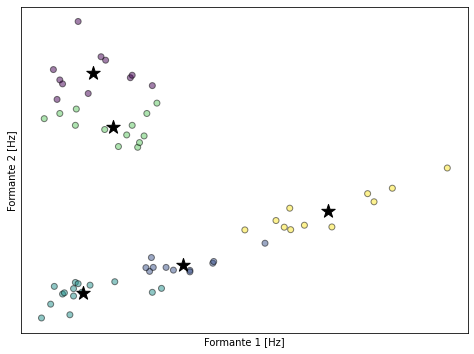

In [22]:
plt.figure(1, figsize=(8, 6))
plt.clf()
plt.scatter(X[0], X[1],c=kmeans.labels_, alpha=.5, edgecolor='k')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, marker = '*', c='k', edgecolor=None)
plt.xlabel('Formante 1 [Hz]')
plt.ylabel('Formante 2 [Hz]')
plt.xticks(())
plt.yticks(())

Análisis de clusters

In [23]:
tmp = pd.DataFrame({'Labels': df.target, 'Clusters': kmeans.labels_})# Create a DataFrame with labels and varieties as columns: df
ct = pd.crosstab(tmp['Labels'], tmp['Clusters']) # Create crosstab: ct

In [24]:
print(ct)

Clusters  0   1   2  3   4
Labels                    
A         0   1   0  0  11
E         3   0   0  9   0
I         8   0   0  4   0
O         0  10   2  0   0
U         0   0  13  0   0


In [25]:
from sklearn.metrics import adjusted_rand_score
ari0 = adjusted_rand_score(df.target, kmeans.labels_)

In [26]:
print(ari0)

0.667814355479043


De la matriz de confusión surge que las mayores confusiones se dan entre la E y la I.

## 4.2 Método SVM

Primero pruebo con dos vocales para hacer SVM binario. Pruebo con la E e I que aparecen algunas confusines en kmeans

In [27]:
df2=df.loc[(df['target'] == 'E') | (df['target'] == 'I')]

In [28]:
X=np.array(df2[[0,1]].values)
y=df2.iloc[:,2:].values.ravel()

C = 1.0  # SVM regularization parameter
clf = svm.SVC(kernel='linear', C=C)
clf.fit(X, y)

SVC(kernel='linear')

Los vectores son

In [29]:
clf.support_vectors_

array([[ 374., 2026.],
       [ 430., 2446.],
       [ 310., 2060.]])

código para dibujar

In [30]:
codes = {'E': 0, 'I': 1}

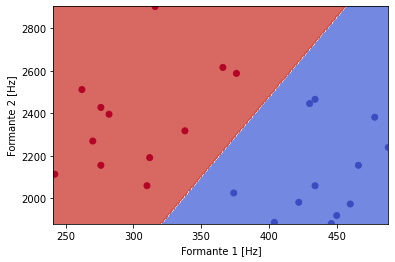

In [31]:
graph_svm(X,y,clf,codes,alpha=0.8)

SVM multiclase

In [32]:
X=np.array(df[[0,1]].values)
y=df.iloc[:,2:].values.ravel()

C = 1.0  # SVM regularization parameter
clf = svm.SVC(kernel='poly',degree=3, C=C) 
clf.fit(X, y)

SVC(kernel='poly')

In [33]:
codes = {'A':0,'E': 1, 'I': 2, 'O':3, 'U':4}

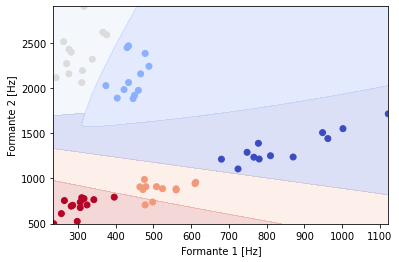

In [34]:
graph_svm(X,y,clf,codes,alpha=0.2)

## 5. Metodos Supervisados

## 5.1 Separacion train / test

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42,stratify=y)

In [ ]:
x_train.shape

(45, 2)

In [ ]:
y_train.shape

(45, 1)

In [ ]:
y_train.value_counts()

target
A         9
E         9
I         9
O         9
U         9
dtype: int64

In [ ]:
x_test.shape

(16, 2)

In [ ]:
y_test.shape

(16, 1)

In [ ]:
y_test.value_counts()

target
U         4
A         3
E         3
I         3
O         3
dtype: int64

## 5.2 Estandarizacion features numericos - Encoding del target

Estandarizacion de los features numericos

In [ ]:
num_scaler = StandardScaler()

In [ ]:
x_train = num_scaler.fit_transform(x_train)

In [ ]:
x_test = num_scaler.transform(x_test)

Encoding del target categorico

In [ ]:
cat_encoder = LabelEncoder()

In [ ]:
y_train = cat_encoder.fit_transform(y_train)

C:\Users\ccollado\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [ ]:
y_test = cat_encoder.transform(y_test)